# Comparisons and analysis

This notebook is for getting the simulated data done on the cluster and then doing funky comparisons and analysis

In [36]:
# First Import the packages.
from tvb.simulator.lab import *
from tvb.simulator.plot.tools import *
import numpy as np
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
from matplotlib.colors import ListedColormap
from turbo_colormap import *
from scipy import stats
#matplotlib.style.use('ggplot')
import inspect
import os
import csv 
import time

import glob
import pandas as pd

# Input Simulation Pipeline
from SimulationPipeline import *

# Now Import our data from our data folder:

# Get all csv filenames in a folder
all_files = glob.glob("do-not-track/*.csv")
#all_files

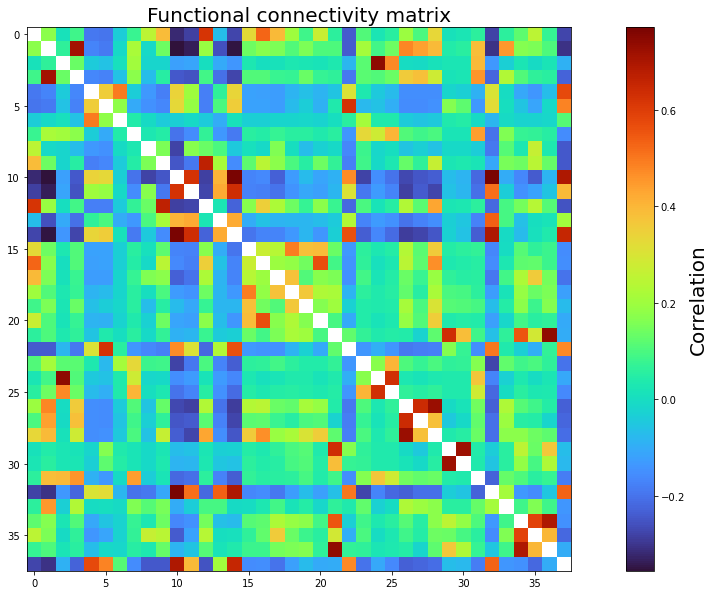

In [37]:
# Import Experimental Mouse Data FCM
FCM_exp = np.genfromtxt('FCM_MouseExperimental.csv',delimiter = "\t")

# Set diagonals to NaN
np.fill_diagonal(FCM_exp,np.nan)

cs=plt.imshow(FCM_exp, cmap=ListedColormap(turbo_colormap_data), aspect='equal', interpolation='none')
plt.title('Functional connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Correlation', fontsize=20)
#plt.yticks([0,1,2,3])

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


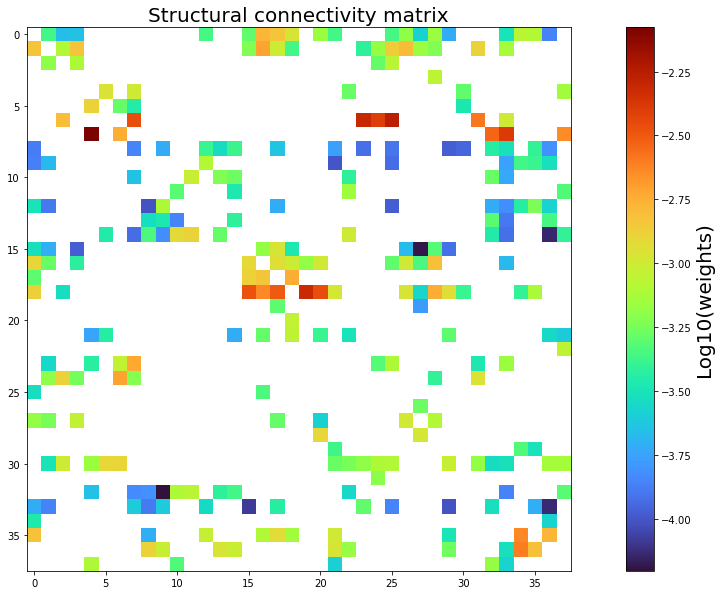

In [38]:
# Load the connectivity data from a zip file. 
con = connectivity.Connectivity.from_file(os.getcwd() +"/Connectomes/MouseCortex.zip")

# Change to Connectome to Binary if desired:
#if ParamsDict["BINARY"]==True:
#    con.weights = con.weights!=0

# Visualize the structural connectivity matrix
plt.subplots()
cs=plt.imshow(np.log10(con.weights), cmap=ListedColormap(turbo_colormap_data), aspect='equal', interpolation='none')
plt.title('Structural connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Log10(weights)', fontsize=20)
#plt.yticks([0,1,2,3])

# Building Heterogeneous Array for w_ei

In [25]:
# Empty dict
ParamsDict = { }

# Name of import file/zip - Which contains connectivity data.
ParamsDict["name"] = "MouseCortex"

# Monitors or not?  (Aka BOLD or not?)
ParamsDict["BOLD"] = True

# Change to Binary Connectome? (If True, will change the connectome into binary)
ParamsDict["BINARY"] = True

# Snip is the the number of elements you wish to snip at the start to remove the initial condition effects.
ParamsDict["Snip"] = 10
# Note, if BOLD = False, Snip gets multiplied by 1000, later in the SimulationPipeline code.  Not the actual dictionary element though.  

# Set the Random State/Seed for the Stochastic Integrator:
ParamsDict["RandState"] = 118

# Remove ith indexed region (7 corresponds to Frontal Pole Cerebral Cortex)
ParamsDict["REMOVE"] = [7]

# Set Simulation Length:
ParamsDict["Simul_length"] = 1.2e6

# Set Linear Coupling Constant:
ParamsDict["G"] = np.array([0.47]) 

# Set integrator time step dt.
ParamsDict["dt"] = 0.1

# Set Additive Noise strength
ParamsDict["noise"] = np.array([0.000013])

# Set Wilson Cowan Model Parameters
ParamsDict["MODEL_c_ee"] = np.array([12.0])
ParamsDict["MODEL_c_ei"] = np.array([15.0])
ParamsDict["MODEL_c_ie"] = np.array([10.0])
ParamsDict["MODEL_c_ii"] = np.array([8.0])

# Define Model
ParamsDict["MODEL"] = models.WilsonCowan(c_ee=ParamsDict["MODEL_c_ee"],c_ei=ParamsDict["MODEL_c_ei"],c_ie=ParamsDict["MODEL_c_ie"] ,c_ii=ParamsDict["MODEL_c_ii"]) 



In [4]:
df = pd.read_csv("CortexDensities.csv",delimiter=",")
w_ei = (df.excitatory/df.inhibitory)
# Sort w_ei
w_ei= pd.DataFrame(w_ei)
#w_ei.sort_values(by=df.columns[1])

w_ei.columns = ["Ratio"]
df1 = w_ei.sort_values(by="Ratio")

# Add Gradient.  + Profit. 
df1["Gradient"] = 12 + np.linspace(0,6,38)
Grad = df1.sort_index()["Gradient"].values
Grad

array([16.37837838, 13.45945946, 13.2972973 , 12.16216216, 14.59459459,
       13.62162162, 15.24324324, 12.        , 18.        , 17.18918919,
       15.89189189, 15.72972973, 16.7027027 , 16.54054054, 16.86486486,
       15.40540541, 14.91891892, 17.02702703, 17.83783784, 15.56756757,
       12.64864865, 16.05405405, 15.08108108, 13.94594595, 12.48648649,
       12.81081081, 13.78378378, 12.32432432, 14.27027027, 14.10810811,
       14.43243243, 12.97297297, 14.75675676, 13.13513514, 17.67567568,
       17.51351351, 17.35135135, 16.21621622])

In [6]:
df = pd.read_csv("CortexDensities.csv",delimiter=",")
E_pop = df.excitatory.values
I_pop = df.inhibitory.values
E_mean = np.mean(E_pop)
I_mean = np.mean(I_pop)

# E_normalised is -0.88 to 0.58
E_normalised = (E_pop-E_mean)/E_mean
# I_normalised is - 0.48 to 2.28
I_normalised = (I_pop-I_mean)/I_mean
# Sigma
sigma = 1 
# Homogeneous Coupling constants
h_ee = ParamsDict["MODEL_c_ee"] 
h_ei = ParamsDict["MODEL_c_ei"] 
h_ie = ParamsDict["MODEL_c_ie"] 
h_ii = ParamsDict["MODEL_c_ii"] 

# Heterogeneous Coupling Constants (array)
ParamsDict["MODEL_c_ie"] = h_ie * (1 + sigma * E_normalised) 
ParamsDict["MODEL_c_ee"] = h_ee  * (1 + sigma * E_normalised) 
ParamsDict["MODEL_c_ii"] = h_ii  * (1 + sigma * I_normalised) 
ParamsDict["MODEL_c_ei"] = h_ei  * (1 + sigma * I_normalised) 

print(E_pop)
print(I_pop)
print(E_mean)
print(I_mean)
print(np.median(E_pop))
print(np.median(I_pop))

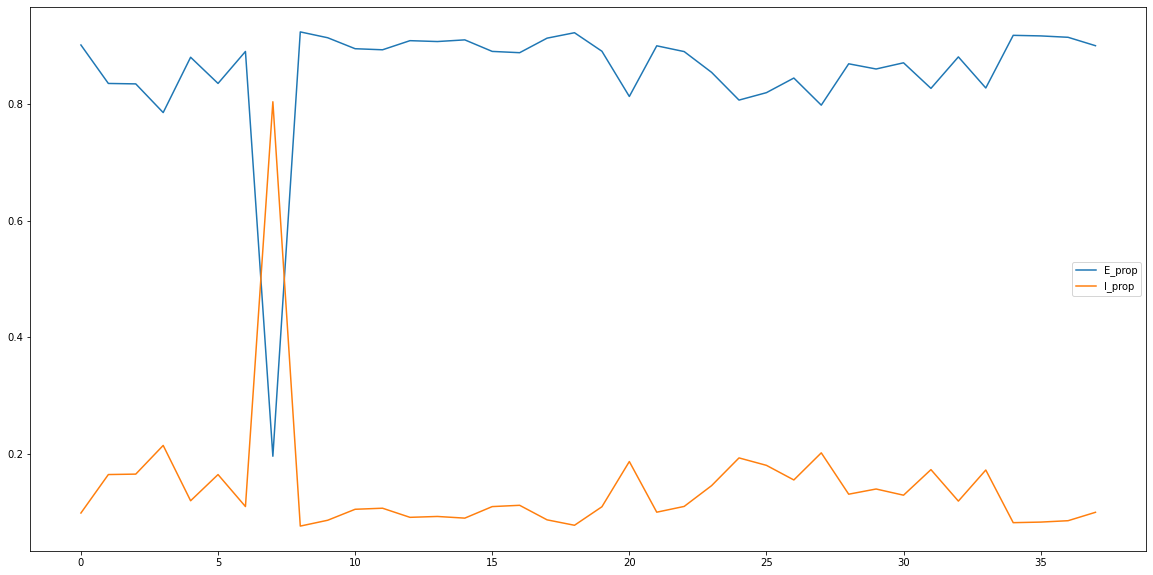

In [10]:
E_prop = E_pop / (E_pop + I_pop)
plt.plot(E_prop)
#print(E_prop)
I_prop = I_pop / (E_pop + I_pop)
plt.plot(I_prop)
plt.legend(("E_prop","I_prop"))

[0.90171434 0.83567232 0.83493242 0.7856988  0.8806731  0.83571393
 0.89059681 0.80425717 0.92415811 0.91412403 0.8953036  0.89347364
 0.90912993 0.9076236  0.9104841  0.89068225 0.88847745 0.91343128
 0.9227535  0.89098901 0.81333326 0.90028936 0.8903981  0.85472195
 0.80711114 0.81988128 0.84496689 0.79843186 0.86941238 0.86049629
 0.87112387 0.82722984 0.88126805 0.82790866 0.9182792  0.91729442
 0.91491776 0.90047804]


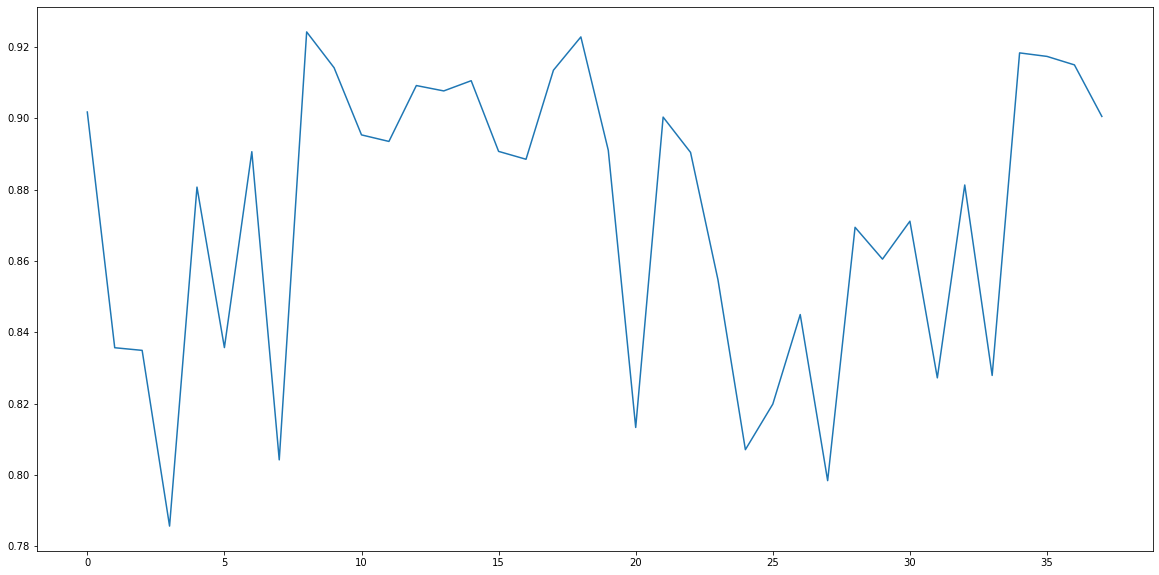

In [11]:
E_prop1 = E_prop
E_prop1[7] = 1 - E_prop1[7]
plt.plot(E_prop1)
print(E_prop1)

# Scorr of Empirical (Experimental) FCM vs SCM of Connectome

This gives a baseline of what the minimum correlation should be like. 

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


Text(0.05, 0.95, 'SpearmanrResult(correlation=0.3936670530573764, pvalue=2.4789217444587726e-53)')

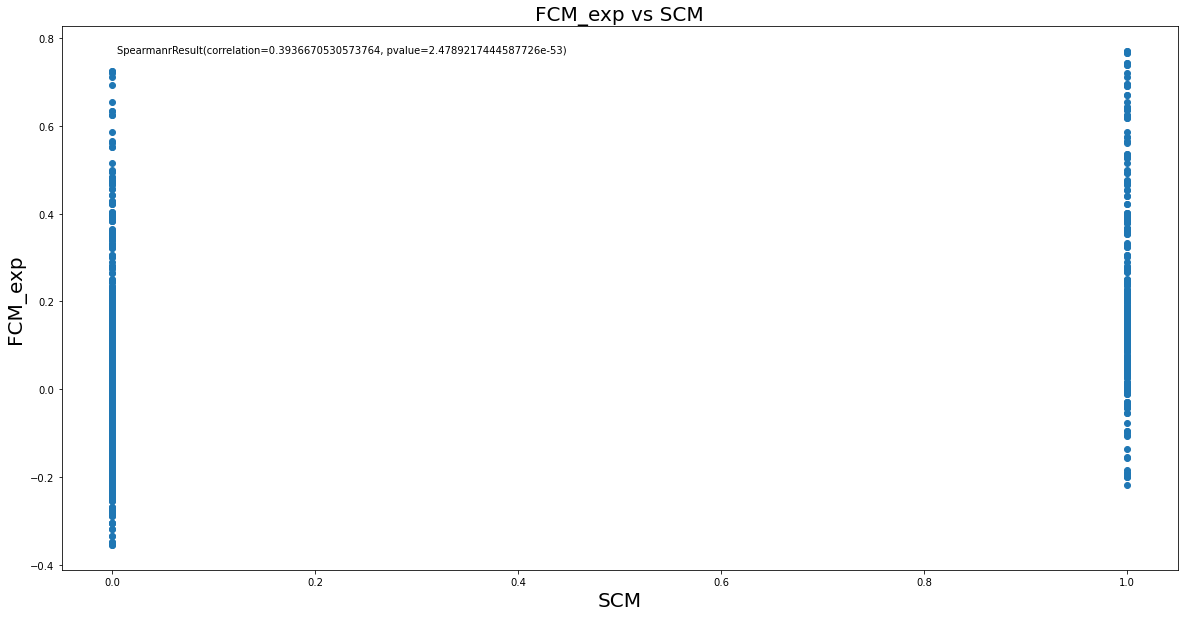

In [3]:
# Import Experimental Mouse Data FCM
FCM_exp = np.genfromtxt('FCM_MouseExperimental.csv',delimiter = "\t")
# Simualted FCM
#FCM_sim = np.genfromtxt(all_files[4],delimiter="\t")
# Set up input Parameters for entire pipeline as dictionary elements here:

# Empty dict
ParamsDict = { }

# Name of import file/zip - Which contains connectivity data.
ParamsDict["name"] = "MouseCortex"

con = connectivity.Connectivity.from_file(os.getcwd() +"/Connectomes/" + ParamsDict["name"] + ".zip")

# Set SCM as Binary
con.weights = con.weights!=0
SCM = con.weights

# Comparing FC_experimental Vs SCM with Spearman Correlation

# Set diagonals to NaN
np.fill_diagonal(FCM_exp,np.nan)
np.fill_diagonal(SCM,np.nan)
# Check if SCM is symmetric: 
Sym_check = numpy.allclose(SCM, SCM.T,equal_nan=True)
if Sym_check == True:
    # Grab Upper triangles
    FCM_Upper = FCM_exp[np.triu_indices(FCM_exp.shape[0], k = 1)]
    SCM_Upper = SCM[np.triu_indices(FCM_sim.shape[0], k = 1)]

elif Sym_check == False:
    # If SCM is not symmetric, need to calcualte spearman corr for entire matrix.
    # Remove all Nans for SCM and FCM
    SCM_Upper = SCM[~numpy.isnan(SCM)]
    FCM_Upper = FCM_exp[~numpy.isnan(FCM_exp)]


# Spearman Correlation
SCorr = stats.spearmanr(a=FCM_Upper,b=SCM_Upper)
#print(SCorr)

# Scatterplot
plt.scatter(SCM_Upper,FCM_Upper)
plt.xlabel('SCM', fontsize=20)
plt.ylabel('FCM_exp', fontsize=20)
plt.title('FCM_exp vs SCM', fontsize=20)
plt.annotate(SCorr, xy=(0.05, 0.95), xycoords='axes fraction')

In [39]:
# Non-binary version

# Import Experimental Mouse Data FCM
FCM_exp = np.genfromtxt('FCM_MouseExperimental.csv',delimiter = "\t")
# Simualted FCM
#FCM_sim = np.genfromtxt(all_files[4],delimiter="\t")
# Set up input Parameters for entire pipeline as dictionary elements here:

# Empty dict
ParamsDict = { }

# Name of import file/zip - Which contains connectivity data.
ParamsDict["name"] = "MouseCortex"

con = connectivity.Connectivity.from_file(os.getcwd() +"/Connectomes/" + ParamsDict["name"] + ".zip")

# Comparing FC_experimental Vs SCM with Spearman Correlation

# Set diagonals to NaN
np.fill_diagonal(FCM_exp,np.nan)
np.fill_diagonal(SCM,np.nan)
# Check if SCM is symmetric: 
Sym_check = numpy.allclose(SCM, SCM.T,equal_nan=True)
if Sym_check == True:
    # Grab Upper triangles
    FCM_Upper = FCM_exp[np.triu_indices(FCM_exp.shape[0], k = 1)]
    SCM_Upper = SCM[np.triu_indices(FCM_sim.shape[0], k = 1)]

elif Sym_check == False:
    # If SCM is not symmetric, need to calcualte spearman corr for entire matrix.
    # Remove all Nans for SCM and FCM
    SCM_Upper = SCM[~numpy.isnan(SCM)]
    FCM_Upper = FCM_exp[~numpy.isnan(FCM_exp)]


# Spearman Correlation
SCorr = stats.spearmanr(a=FCM_Upper,b=SCM_Upper)
#print(SCorr)

# Scatterplot
plt.scatter(SCM_Upper,FCM_Upper)
plt.xlabel('SCM', fontsize=20)
plt.ylabel('FCM_exp', fontsize=20)
plt.title('FCM_exp vs SCM', fontsize=20)
plt.annotate(SCorr, xy=(0.05, 0.95), xycoords='axes fraction')# Import Experimental Mouse Data FCM
FCM_exp = np.genfromtxt('do-not-track\\FCM_MouseExperimental.csv',delimiter = "\t")
# Simualted FCM
#FCM_sim = np.genfromtxt(all_files[4],delimiter="\t")
# Set up input Parameters for entire pipeline as dictionary elements here:

# Empty dict
ParamsDict = { }

# Name of import file/zip - Which contains connectivity data.
ParamsDict["name"] = "MouseCortex"

con = connectivity.Connectivity.from_file(os.getcwd() +"/Connectomes/" + ParamsDict["name"] + ".zip")

SCM = con.weights

# Comparing FC_experimental Vs SCM with Spearman Correlation

# Set diagonals to NaN
np.fill_diagonal(FCM_exp,np.nan)
np.fill_diagonal(SCM,np.nan)
# Check if SCM is symmetric: 
Sym_check = numpy.allclose(SCM, SCM.T,equal_nan=True)
if Sym_check == True:
    # Grab Upper triangles
    FCM_Upper = FCM_exp[np.triu_indices(FCM_exp.shape[0], k = 1)]
    SCM_Upper = SCM[np.triu_indices(FCM_sim.shape[0], k = 1)]

elif Sym_check == False:
    # If SCM is not symmetric, need to calcualte spearman corr for entire matrix.
    # Remove all Nans for SCM and FCM
    SCM_Upper = SCM[~numpy.isnan(SCM)]
    FCM_Upper = FCM_exp[~numpy.isnan(FCM_exp)]


# Spearman Correlation
SCorr = stats.spearmanr(a=FCM_Upper,b=SCM_Upper)
#print(SCorr)

# Scatterplot
plt.scatter(SCM_Upper,FCM_Upper)
plt.xlabel('SCM', fontsize=20)
plt.ylabel('FCM_exp', fontsize=20)
plt.title('FCM_exp vs SCM', fontsize=20)
plt.annotate(SCorr, xy=(0.05, 0.95), xycoords='axes fraction')

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


NameError: name 'SCM' is not defined

# Comparison of SCorr vs Selected Variable (G = Coupling constant)

Both SC-FC and FC-FC
 

In [61]:
def par_extract(file):
    # Extracts the characters between square brackets.
    s_filter = ""
    x = False
    for i in file:
        if i == "[": x = True
        elif i == "]": x = False
        elif x: s_filter += i

    return s_filter

# Get Scorr csv filenames in a folder
Scorr_files = glob.glob("do-not-track/LCycle*Scorr*.csv")

SCFC = []
FCFC = []
G_value = []

# Loop to populate the empty array with the numbers from the Scorr csv files:

for item in Scorr_files:
    a = np.genfromtxt(item)
    SCFC.append(a[0])
    FCFC.append(a[2])
    G_value.append(par_extract(item))

print(Scorr_files)
print("SCFC =",SCFC)
print(numpy.amax(SCFC))
print(numpy.where(SCFC==np.amax(SCFC)))
print("FCFC =",FCFC)
print(numpy.amax(FCFC))
print(numpy.where(FCFC==np.amax(FCFC)))

# Check File order. 
 # print(Scorr_files)

['do-not-track\\LCycle_G[0.05]_MouseCortex_Scorr_20200729-113231_.csv', 'do-not-track\\LCycle_G[0.15]_MouseCortex_Scorr_20200729-114612_.csv', 'do-not-track\\LCycle_G[0.1]_MouseCortex_Scorr_20200729-113208_.csv', 'do-not-track\\LCycle_G[0.25]_MouseCortex_Scorr_20200729-115956_.csv', 'do-not-track\\LCycle_G[0.2]_MouseCortex_Scorr_20200729-114621_.csv', 'do-not-track\\LCycle_G[0.35]_MouseCortex_Scorr_20200729-121421_.csv', 'do-not-track\\LCycle_G[0.3]_MouseCortex_Scorr_20200729-120021_.csv', 'do-not-track\\LCycle_G[0.45]_MouseCortex_Scorr_20200729-122826_.csv', 'do-not-track\\LCycle_G[0.4]_MouseCortex_Scorr_20200729-121411_.csv', 'do-not-track\\LCycle_G[0.55]_MouseCortex_Scorr_20200729-124348_.csv', 'do-not-track\\LCycle_G[0.5]_MouseCortex_Scorr_20200729-122842_.csv', 'do-not-track\\LCycle_G[0.65]_MouseCortex_Scorr_20200729-125652_.csv', 'do-not-track\\LCycle_G[0.6]_MouseCortex_Scorr_20200729-124235_.csv', 'do-not-track\\LCycle_G[0.75]_MouseCortex_Scorr_20200729-131054_.csv', 'do-not-tra

In [62]:
# Sort it:
def sorter(X,Y):
    Z = [x for _,x in sorted(zip(Y,X))]
    return Z

SCFC = sorter(SCFC,G_value)
FCFC = sorter(FCFC,G_value)
G_value = sorted(G_value)

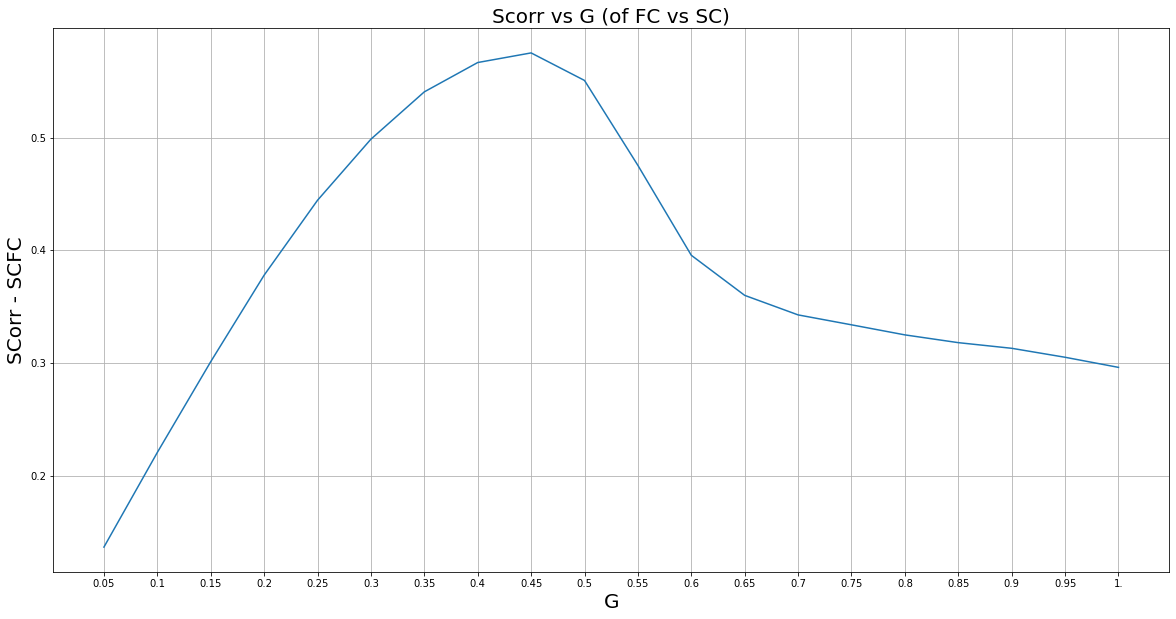

In [63]:
# Graph it: 
plt.plot(G_value,SCFC)
plt.xlabel('G', fontsize=20)
plt.ylabel('SCorr - SCFC', fontsize=20)
plt.title('Scorr vs G (of FC vs SC)', fontsize=20)
plt.grid()

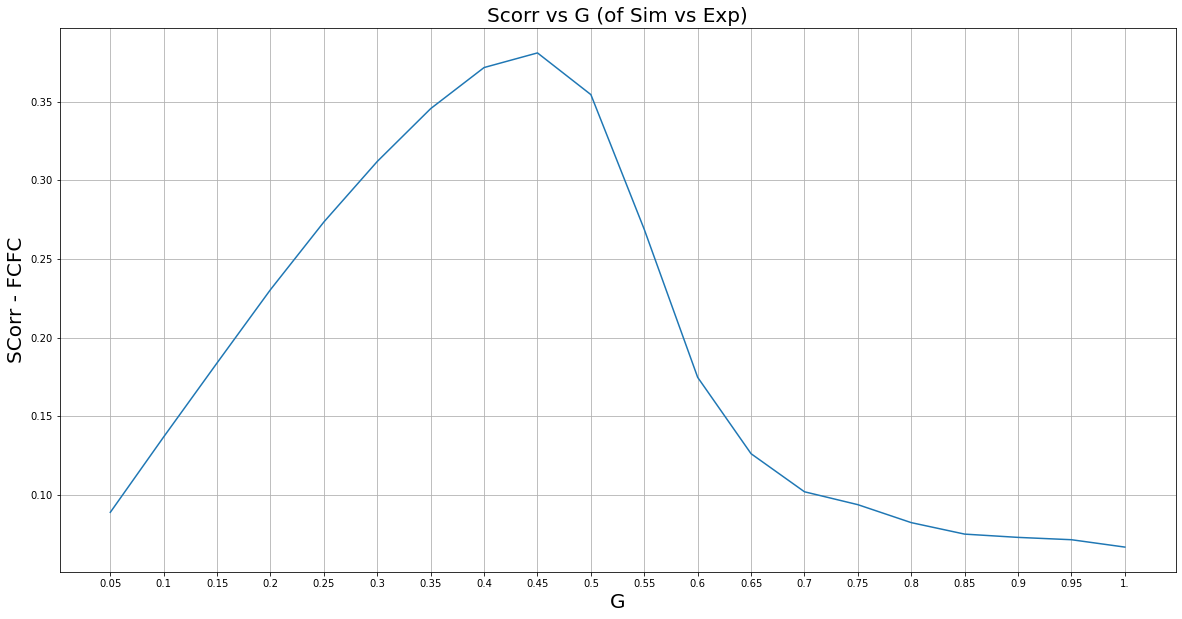

In [64]:
# Graph it: 
plt.plot(G_value,FCFC)
plt.xlabel('G', fontsize=20)
plt.ylabel('SCorr - FCFC', fontsize=20)
plt.title('Scorr vs G (of Sim vs Exp)', fontsize=20)
plt.grid()

# Performing a Simulation Run


In [62]:
# These are Default Values for ParamsDict.  

# Empty dict
ParamsDict = { }

# Name of import file/zip - Which contains connectivity data.
ParamsDict["name"] = "MouseCortex"

# Calculate FC-FC for Mouse?
ParamsDict["FCFC"] = True

# Monitors or not?  (Aka BOLD or not?)
ParamsDict["BOLD"] = True

# Change to Binary Connectome? (If True, will change the connectome into binary)
ParamsDict["BINARY"] = True

# Snip is the the number of elements you wish to snip at the start to remove the initial condition effects.
ParamsDict["Snip"] = 10
# Note, if BOLD = False, Snip gets multiplied by 1000, later in the SimulationPipeline code.  Not the actual dictionary element though.  

# Set the Random State/Seed for the Stochastic Integrator:
ParamsDict["RandState"] = 118

# Remove ith indexed region (7 corresponds to Frontal Pole Cerebral Cortex) - Give it a list if removing multiple regions.  Empty list removes nothing. 
ParamsDict["REMOVE"] = [7]

# Set Simulation Length:
ParamsDict["Simul_length"] = 1.2e4

# Set Linear Coupling Constant:
ParamsDict["G"] = np.array([0.47]) 

# Set integrator time step dt.
ParamsDict["dt"] = 0.1

# Set Additive Noise strength
ParamsDict["noise"] = np.array([0.000013])

# Set Wilson Cowan Model Parameters
ParamsDict["MODEL_c_ee"] = np.array([11.0])
ParamsDict["MODEL_c_ei"] = np.array([10.0])
ParamsDict["MODEL_c_ie"] = np.array([10.0])
ParamsDict["MODEL_c_ii"] = np.array([1.0])

# Model is now defined within SimulationPipeline.py
# However if you adjusting parameters other than these Coupling Parameters, then you need to redefine the model in this file per run.

# Params Dict tag (extra note tags for the name - Example to denote what's being changed/looped.)
ParamsDict["tag"] = ""

In [63]:
ParamsDict["tag"] = "nonBOLD_test" 
Simul_Pipeline(ParamsDict=ParamsDict)

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.
SpearmanrResult(correlation=0.5538129997677929, pvalue=8.070795397130483e-114)
SpearmanrResult(correlation=0.451315112499323, pvalue=1.4198964421133655e-36)


# Looking at a simulation run

In [65]:
# Ye dunno why having the closing square bracket messes up glob glob. 
Sim_run_files = glob.glob("do-not-track/LCycle_G[0.45*_.csv")
Sim_run_files

['do-not-track\\LCycle_G[0.45]_MouseCortex_FCM_20200729-122826_.csv',
 'do-not-track\\LCycle_G[0.45]_MouseCortex_Params_20200729-122826_.csv',
 'do-not-track\\LCycle_G[0.45]_MouseCortex_Scorr_20200729-122826_.csv',
 'do-not-track\\LCycle_G[0.45]_MouseCortex_Tseries_20200729-122826_.csv']

In [66]:
# Read file import data
#df = pd.read_csv(all_files[11],delimiter="\t",header=None)
# Genfromtxt gives us a np array. 
df = np.genfromtxt(Sim_run_files[-1],delimiter="\t")

bold_time = df[0]
bold_data = df[1:]

In [67]:
'''
# plt.subplots()

#plt.figure(num=None, figsize=(60, 30), dpi=80, facecolor='w', edgecolor='k')
for tseries in bold_data:
    plt.plot(bold_time,tseries)

plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Amplitude (au)', fontsize=20)
plt.title('Simulated BOLD timeseries', fontsize=20)
#plt.legend(('0','1','2','3','4'))
plt.legend(range(38))
'''

"\n# plt.subplots()\n\n#plt.figure(num=None, figsize=(60, 30), dpi=80, facecolor='w', edgecolor='k')\nfor tseries in bold_data:\n    plt.plot(bold_time,tseries)\n\nplt.xlabel('Time (ms)', fontsize=20)\nplt.ylabel('Amplitude (au)', fontsize=20)\nplt.title('Simulated BOLD timeseries', fontsize=20)\n#plt.legend(('0','1','2','3','4'))\nplt.legend(range(38))\n"

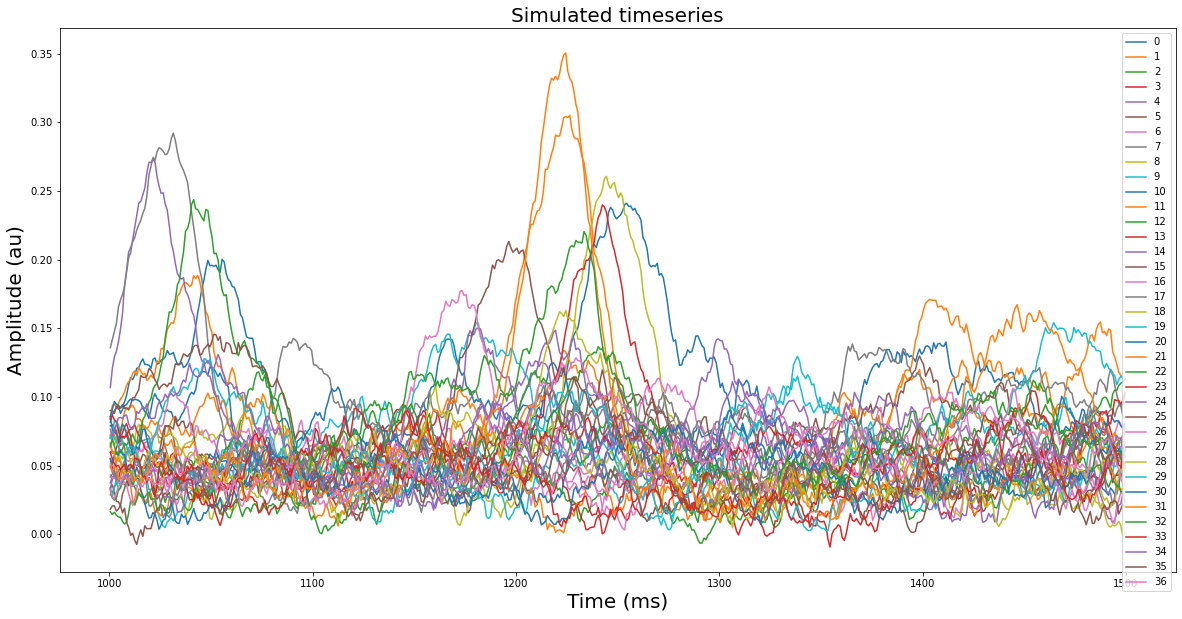

In [68]:
# plt.subplots()

#plt.figure(num=None, figsize=(60, 30), dpi=80, facecolor='w', edgecolor='k')
for tseries in bold_data:
    plt.plot(bold_time[0:500],tseries[0:500])

plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Amplitude (au)', fontsize=20)
plt.title('Simulated timeseries', fontsize=20)
#plt.legend(('0','1','2','3','4'))
plt.legend(range(38))

In [69]:
Scorra = np.genfromtxt(Sim_run_files[-2])
Scorra

array([5.75031159e-001, 4.30856011e-118, 3.81107414e-001, 1.89529634e-024])

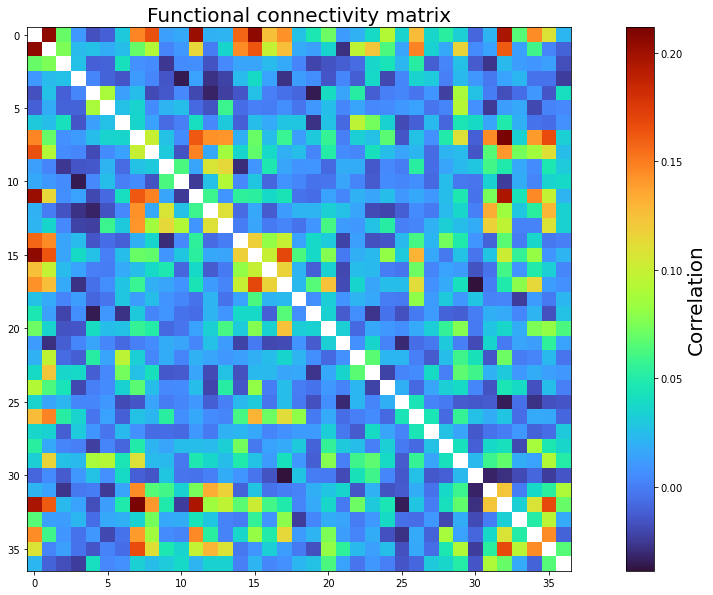

In [70]:
# Plot Simulated FCM
FCM_sim = np.genfromtxt(Sim_run_files[-4],delimiter="\t")

# ListedColormap(turbo_colormap_data)
cs=plt.imshow(FCM_sim, cmap=ListedColormap(turbo_colormap_data), aspect='equal', interpolation='none')
plt.title('Functional connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Correlation', fontsize=20)
#plt.yticks([0,1,2,3])

Text(0.05, 0.95, 'SpearmanrResult(correlation=0.381107414185612, pvalue=1.895296343202489e-24)')

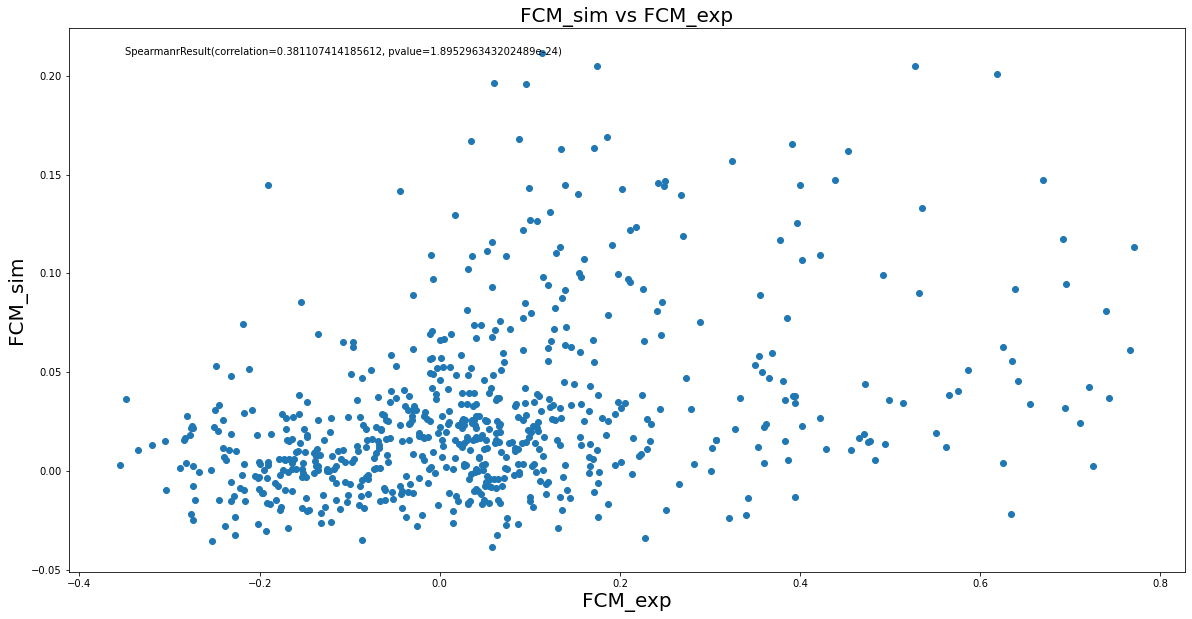

In [71]:
ParamsDict["REMOVE"] = [7]

FCM_exp = np.genfromtxt('FCM_MouseExperimental.csv',delimiter = "\t")
# Set diagonals to NaN
np.fill_diagonal(FCM_exp,np.nan)

# Remove the ith row and column in FCM (i.e. the specified region)
FCM_exp = np.delete(FCM_exp,obj=ParamsDict["REMOVE"],axis=0)
FCM_exp = np.delete(FCM_exp,obj=ParamsDict["REMOVE"],axis=1)

FCM_Exp_U = FCM_exp[np.triu_indices(FCM_exp.shape[0], k = 1)]
FCM_Sim_U = FCM_sim[np.triu_indices(FCM_sim.shape[0], k = 1)]

# Spearman Correlation
SCorr = stats.spearmanr(a=FCM_Exp_U,b=FCM_Sim_U)
#print(SCorr)

# Scatterplot
plt.scatter(FCM_Exp_U,FCM_Sim_U)
plt.xlabel('FCM_exp', fontsize=20)
plt.ylabel('FCM_sim', fontsize=20)
plt.title('FCM_sim vs FCM_exp', fontsize=20)
plt.annotate(SCorr, xy=(0.05, 0.95), xycoords='axes fraction')